In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Serving PyTorch image models with prebuilt containers on Vertex AI


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

This tutorial demonstrates how to upload and deploy a PyTorch image model using a prebuilt serving container and how to make online and batch predictions.

Vertex AI provides prebuilt containers for serving predictions and explanations from trained model artifacts. Using a pre-built container is generally simpler than creating your own custom container for prediction.

Learn more about [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers).

### Objective

In this tutorial, you learn how to package and deploy a PyTorch image classification model using a prebuilt Vertex AI container with TorchServe for serving online and batch predictions.

This tutorial uses the following Google Cloud ML services and resources:

- `Vertex AI Model Registry`
- `Vertex AI Model` resources
- `Vertex AI Endpoint` resources

The steps performed include:

- Download a pretrained image model from PyTorch
- Create a custom model handler
- Package model artifacts in a model archive file
- Upload model for deployment
- Deploy model for prediction
- Make online predictions
- Make batch predictions

### Model

This tutorial uses a pretrained image model [resnet18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) from the PyTorch TorchVision.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [38]:
! pip3 install --upgrade google-cloud-aiplatform==1.23.0 \
                                 tensorflow==2.12.0 \
                                 torch==2.0.0 \
                                 torchvision==0.15.1 \
                                 torch-model-archiver==0.7.1 \
                                 packaging==14.3

### Colab only: Uncomment the following cell to restart the kernel.

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, see the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [39]:
PROJECT_ID = "vision-ai-konnect"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [40]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [41]:
BUCKET_URI = f"gs://test-vision-ai-konnect-test-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [42]:
import base64
import json
import os
import pathlib
import urllib.request

import tensorflow as tf
import torch
from google.cloud import aiplatform
from PIL import Image
from torchvision import models

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [43]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Download a pre-trained image model

Download the pretrained image model [resnet18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) from the PyTorch TorchVision.

In [44]:
# Create a local directory for model artifacts
# https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n.pt
yolo_model_path = "yolo_model"

!rm -r $yolo_model_path
!mkdir $yolo_model_path

yolo_model_name = "yolov5n"
yolo_model_file = f"{yolo_model_path}/{yolo_model_name}.pt"

In [45]:
import urllib.request
urllib.request.urlretrieve("https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n.pt", f"{yolo_model_path}/{yolo_model_name}.pt")

('yolo_model/yolov5n.pt', <http.client.HTTPMessage at 0x7fb71a0ded10>)

## Create a custom model handler

A custom model handler is a Python script that you package with the model when you use the model archiver. The script typically defines how to pre-process input data, invoke the model and post-process the output.

TorchServe has [default handlers](https://pytorch.org/serve/default_handlers.html) for `image_classifier`, `image_segmenter`, `object_detector` and `text_classifier`. In this tutorial, you create a custom handler extending the default [`image_classifier`](https://github.com/pytorch/serve/blob/master/ts/torch_handler/image_classifier.py) handler.


In [46]:
yolo_hander_file = f"{yolo_model_path}/yolo_custom_handler.py"

Use the handler from: https://gist.github.com/joek13/b895db0cd50a7c71a123611885057c69

In [47]:
%%writefile {yolo_hander_file}

"""Custom TorchServe model handler for YOLOv5 models.
"""
from ts.torch_handler.base_handler import BaseHandler
import numpy as np
import base64
import torch
import torchvision.transforms as tf
import torchvision
import io
from PIL import Image


class ModelHandler(BaseHandler):
    """
    A custom model handler implementation.
    """

    img_size = 640
    """Image size (px). Images will be resized to this resolution before inference.
    """

    def __init__(self):
        # call superclass initializer
        super().__init__()

    def preprocess(self, data):
        """Converts input images to float tensors.
        Args:
            data (List): Input data from the request in the form of a list of image tensors.
        Returns:
            Tensor: single Tensor of shape [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
        """
        images = []

        transform = tf.Compose([
            tf.ToTensor(),
            tf.Resize((self.img_size, self.img_size))
        ])

        # load images
        # taken from https://github.com/pytorch/serve/blob/master/ts/torch_handler/vision_handler.py

        # handle if images are given in base64, etc.
        for row in data:
            # Compat layer: normally the envelope should just return the data
            # directly, but older versions of Torchserve didn't have envelope.
            image = row.get("data") or row.get("body")
            if isinstance(image, str):
                # if the image is a string of bytesarray.
                image = base64.b64decode(image)

            # If the image is sent as bytesarray
            if isinstance(image, (bytearray, bytes)):
                image = Image.open(io.BytesIO(image))
            else:
                # if the image is a list
                image = torch.FloatTensor(image)

            # force convert to tensor
            # and resize to [img_size, img_size]
            image = transform(image)

            images.append(image)

        # convert list of equal-size tensors to single stacked tensor
        # has shape BATCH_SIZE x 3 x IMG_SIZE x IMG_SIZE
        images_tensor = torch.stack(images).to(self.device)

        return images_tensor

    def postprocess(self, inference_output):
        # perform NMS (nonmax suppression) on model outputs
        pred = non_max_suppression(inference_output[0])

        # initialize empty list of detections for each image
        detections = [[] for _ in range(len(pred))]

        for i, image_detections in enumerate(pred):  # axis 0: for each image
            for det in image_detections:  # axis 1: for each detection
                # x1,y1,x2,y2 in normalized image coordinates (i.e. 0.0-1.0)
                xyxy = det[:4] / self.img_size
                # confidence value
                conf = det[4].item()
                # index of predicted class
                class_idx = int(det[5].item())
                # get label of predicted class
                # if missing, then just return class idx
                label = self.mapping.get(str(class_idx), class_idx)

                detections[i].append({
                    "x1": xyxy[0].item(),
                    "y1": xyxy[1].item(),
                    "x2": xyxy[2].item(),
                    "y2": xyxy[3].item(),
                    "confidence": conf,
                    "class": label
                })

        # format each detection
        return detections


def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # (pixels) minimum and maximum box width and height
    min_wh, max_wh = 2, 4096
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [torch.zeros((0, 6), device=prediction.device)
              ] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[
                conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = torchvision.box_iou(
                boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float(
            ) / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

Writing yolo_model/yolo_custom_handler.py


## Download an index_to_name.json file

PyTorch `image_classifier`, `text_classifier` and `object_detector` can all automatically map from numeric classes (0,1,2...) to friendly strings. To do this, simply include `index_to_name.json` that contains a mapping of class number to friendly name in your model archive file.

In [48]:
index_to_name_file = f"{yolo_model_path}/index_to_name.json"

urllib.request.urlretrieve(
    "https://github.com/pytorch/serve/raw/master/examples/image_classifier/index_to_name.json",
    index_to_name_file,
)

('yolo_model/index_to_name.json', <http.client.HTTPMessage at 0x7fb71a174cd0>)

## Package the model artifacts in a model archive file

You package all the model artifacts in a model archive file using the [`Torch model archiver`](https://github.com/pytorch/serve/tree/master/model-archiver).

Note that the prebuilt PyTorch serving containers require the model archive file named as `model.mar` so you need to set the model-name as `model` in the `torch-model-archiver` command.

In [49]:
# Add torch-model-archiver to the PATH
os.environ["PATH"] = f'{os.environ.get("PATH")}:~/.local/bin'

In [50]:
!torch-model-archiver \
  --model-name model \
  --version 0.1 \
  --serialized-file $yolo_model_file \
  --handler $yolo_hander_file \
  --extra-files $index_to_name_file,$yolo_hander_file \
  --export-path $yolo_model_path

## Copy the model artifacts to Cloud Storage

Next, use `gsutil` to copy the model artifacts to your Cloud Storage bucket.

In [51]:
YOLO_MODEL_URI = f"{BUCKET_URI}/{yolo_model_name}"

!gsutil rm -r $YOLO_MODEL_URI
!gsutil cp -r $yolo_model_path $YOLO_MODEL_URI
!gsutil ls -al $YOLO_MODEL_URI

Removing gs://test-vision-ai-konnect-test-vision-ai-konnect-unique/yolov5n/model.mar#1692324844890624...
Removing gs://test-vision-ai-konnect-test-vision-ai-konnect-unique/yolov5n/yolo.mar#1692324844573978...
Removing gs://test-vision-ai-konnect-test-vision-ai-konnect-unique/yolov5n/yolo_custom_handler.py#1692324844989328...
Removing gs://test-vision-ai-konnect-test-vision-ai-konnect-unique/yolov5n/yolov5n.pt#1692324844293295...
/ [4 objects]                                                                   
Operation completed over 4 objects.                                              
Copying file://yolo_model/yolov5n.pt [Content-Type=application/vnd.snesdev-page-table]...
Copying file://yolo_model/model.mar [Content-Type=application/octet-stream]...  
Copying file://yolo_model/index_to_name.json [Content-Type=application/json]... 
Copying file://yolo_model/yolo_custom_handler.py [Content-Type=text/x-python]...
- [4 files][  7.3 MiB/  7.3 MiB]                                       

## Upload model for deployment

Next, you upload the [model](https://cloud.google.com/vertex-ai/docs/reference/rest/v1/projects.locations.models) to `Vertex AI Model Registry`, which will create a `Vertex AI Model` resource for your model. This tutorial uses the PyTorch v1.11 container, but for your own use case, you can choose from the list of [PyTorch prebuilt containers](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers#pytorch).

In [52]:
YOLO_DEPLOY_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/pytorch-cpu.1-11:latest"

yolo_deployed_model = aiplatform.Model.upload(
    display_name=yolo_model_name,
    serving_container_image_uri=YOLO_DEPLOY_IMAGE_URI,
    artifact_uri=YOLO_MODEL_URI,
)

Creating Model
Create Model backing LRO: projects/74220630897/locations/us-central1/models/4395379095895015424/operations/4385376495019753472
Model created. Resource name: projects/74220630897/locations/us-central1/models/4395379095895015424@1
To use this Model in another session:
model = aiplatform.Model('projects/74220630897/locations/us-central1/models/4395379095895015424@1')


## Deploy model for prediction

Next, deploy your model for online prediction. You set the variable `DEPLOY_COMPUTE` to configure the machine type for the [compute resources](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute) you will use for prediction.

In [53]:
DEPLOY_COMPUTE = "n1-standard-4"

yolo_endpoint = deployed_model.deploy(
    deployed_model_display_name=yolo_model_name,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

Creating Endpoint
Create Endpoint backing LRO: projects/74220630897/locations/us-central1/endpoints/2592527472016752640/operations/3866336637965303808
Endpoint created. Resource name: projects/74220630897/locations/us-central1/endpoints/2592527472016752640
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/74220630897/locations/us-central1/endpoints/2592527472016752640')
Deploying model to Endpoint : projects/74220630897/locations/us-central1/endpoints/2592527472016752640
Deploy Endpoint model backing LRO: projects/74220630897/locations/us-central1/endpoints/2592527472016752640/operations/7996137496264048640
Endpoint model deployed. Resource name: projects/74220630897/locations/us-central1/endpoints/2592527472016752640


## Make online predictions

### Download an image dataset
In this example, you use the TensorFlow flowers dataset for the input for both online and batch predictions.

In [54]:
data_dir = tf.keras.utils.get_file(
    "flower_photos",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)

data_dir = pathlib.Path(data_dir)
images_files = list(data_dir.glob("daisy/*"))

### Get online predictions

You send a `predict` request with encoded input image data to the `endpoint` and get prediction.

In [55]:
with open(images_files[0], "rb") as f:
    data = {"data": base64.b64encode(f.read()).decode("utf-8")}

response = yolo_endpoint.predict(instances=[data])

{'daisy': 0.6976354718208313, 'rapeseed': 0.2211205512285233, 'picket_fence': 0.01282437145709991}


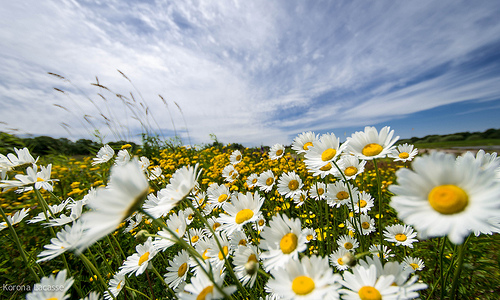

In [56]:
prediction = response.predictions[0]
prediction = dict(sorted(prediction.items(), key=lambda item: item[1], reverse=True))

print(prediction)
image = Image.open(images_files[0])
image

## Make batch predictions

### Create the batch input file

You create a batch input file in JSONL format and store the input file in your Cloud Storage bucket.

Learn more about [Input data requirements](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#input_data_requirements).

In [57]:
TEST_IMAGE_SIZE = 2
test_image_list = []
for i in range(TEST_IMAGE_SIZE):
    test_image_list.append(str(images_files[i]))

gcs_input_uri = f"{BUCKET_URI}/test_images.json"

with tf.io.gfile.GFile(gcs_input_uri, "w") as f:
    for test_image in test_image_list:
        with open(test_image, "rb") as image_f:
            data = {"data": base64.b64encode(image_f.read()).decode("utf-8")}
            f.write(json.dumps(data) + "\n")

### Submit a batch prediction job

In [58]:
JOB_DISPLAY_NAME = f"{model_name}_batch_predict_job_unique"

batch_predict_job = deployed_model.batch_predict(
    job_display_name=JOB_DISPLAY_NAME,
    gcs_source=gcs_input_uri,
    gcs_destination_prefix=BUCKET_URI,
    instances_format="jsonl",
    model_parameters=None,
    machine_type=DEPLOY_COMPUTE,
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/74220630897/locations/us-central1/batchPredictionJobs/2244884504021827584
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/74220630897/locations/us-central1/batchPredictionJobs/2244884504021827584')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/2244884504021827584?project=74220630897
BatchPredictionJob projects/74220630897/locations/us-central1/batchPredictionJobs/2244884504021827584 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/74220630897/locations/us-central1/batchPredictionJobs/2244884504021827584 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/74220630897/locations/us-central1/batchPredictionJobs/2244884504021827584 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/74220630897/locations/us-central1/batchPredictionJobs/2244884

### Get batch predictions

After the batch job completes, the results are written to the Cloud Storage output bucket you specified in the batch request. You call the method `iter_outputs()` to get a list of each Cloud Storage file generated with the results.

In [59]:
bp_iter_outputs = batch_predict_job.iter_outputs()

prediction_files = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction.results"):
        prediction_files.append(blob.name)

In [60]:
prediction_file = prediction_files[0]

results = []
gfile_name = f"{BUCKET_URI}/{prediction_file}"
with tf.io.gfile.GFile(name=gfile_name, mode="r") as gfile:
    for line in gfile.readlines():
        results.append(json.loads(line))

# Take one result as an example and print out the prediction.
prediction = results[0]["prediction"]
prediction = dict(sorted(prediction.items(), key=lambda item: item[1], reverse=True))
print(prediction)

{'daisy': 0.6976350545883179, 'rapeseed': 0.22112062573432922, 'picket_fence': 0.012824376113712788}


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
endpoint.undeploy_all()
endpoint.delete()

deployed_model.delete()
batch_predict_job.delete()

delete_bucket = False
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI